In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from kitti_data import KITTI
from prednet import PredNet
import matplotlib.pyplot as plt
import numpy as np
from debug import info

num_epochs = 150
batch_size = 16
A_channels = (3, 48, 96, 192)
R_channels = (3, 48, 96, 192)
lr = 0.001 # if epoch < 75 else 0.0001
nt = 10 # num of time steps




In [15]:

layer_loss_weights = Variable(torch.FloatTensor([[1.], [0.], [0.], [0.]]))

time_loss_weights = 1./(nt - 1) * torch.ones(nt, 1)
time_loss_weights[0] = 0
time_loss_weights = Variable(time_loss_weights)
plt.plot(layer_loss_weights)

(3, 48, 96, 192, 0)


In [2]:
from skimage.transform import resize
import imageio

gif = imageio.get_reader('stimuli/AM_type1.gif')

# Here's the number you're looking for
number_of_frames = len(gif)
print(number_of_frames)

AM_frames_raw = []
for frame in gif:
    AM_frames_raw.append(resize(frame, (128, 160)))

AM_frames = []
for i in range(10):
    if i < 6:
        if i % 2 == 0:
            AM_frames.append(AM_frames_raw[0])
        else:
            AM_frames.append(AM_frames_raw[5])
    if i >= 6:
        AM_frames.append(AM_frames_raw[3])

10


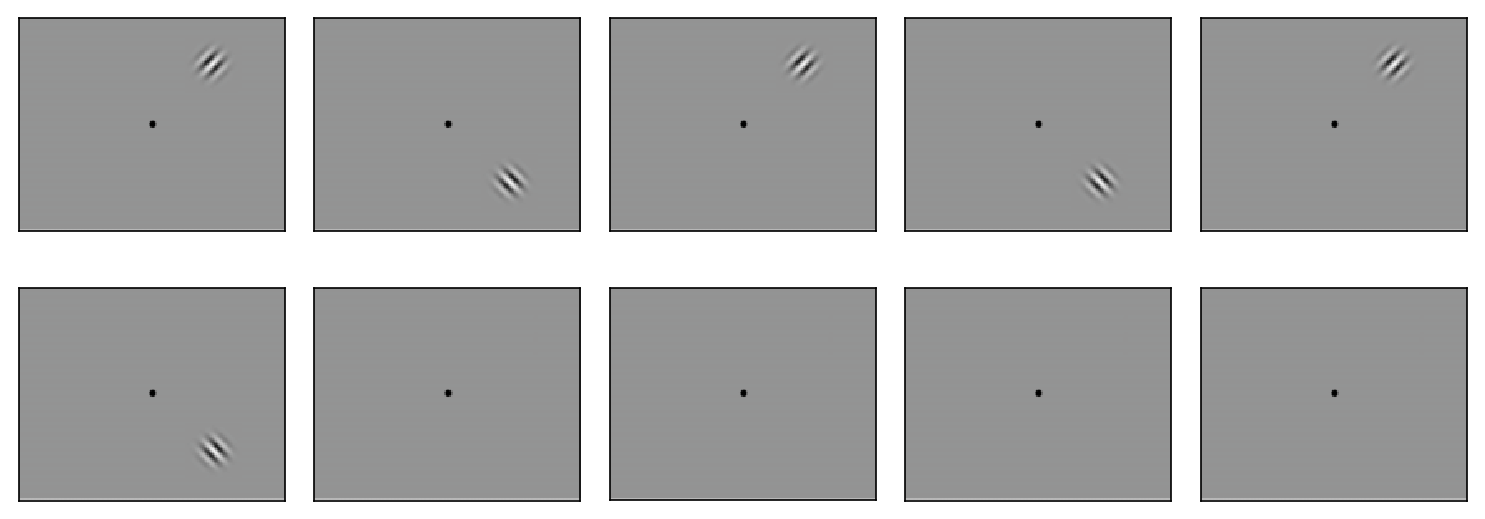

In [3]:
fig, axes = plt.subplots(2,5, figsize=(10,4), dpi=150)
batch = 0
count = 0
for row in range(2):
    for col in range(5):
        axes[row,col].imshow(AM_frames[count])
        axes[row,col].set_xticks([])
        axes[row,col].set_yticks([])
        count += 1
plt.tight_layout()

In [33]:
DATA_DIR = 'kitti_data_raw'
test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

kitti_test = KITTI(test_file, test_sources, nt)

test_loader = DataLoader(kitti_test, batch_size=batch_size, shuffle=False)

model = PredNet(R_channels, A_channels, output_mode='prediction_all')
model.load_state_dict(torch.load('models/training_0030.pt'))
model.cuda()
model.eval()

test_input = next(iter(test_loader))
print(test_input.shape)
test_input = test_input.permute(0, 1, 4, 2, 3).cuda()
print(test_input.shape)
test_output = model(test_input)

torch.Size([16, 10, 128, 160, 3])
torch.Size([16, 10, 3, 128, 160])


/home/jwpark/.local/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/jwpark/.local/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.91 GiB total capacity; 9.70 GiB already allocated; 16.56 MiB free; 9.80 GiB reserved in total by PyTorch)

In [11]:
print(len(test_output)) # 4, 4, 4, 4, 4, 4 ...
print(test_output[0].shape)

40
torch.Size([16, 3, 128, 160])


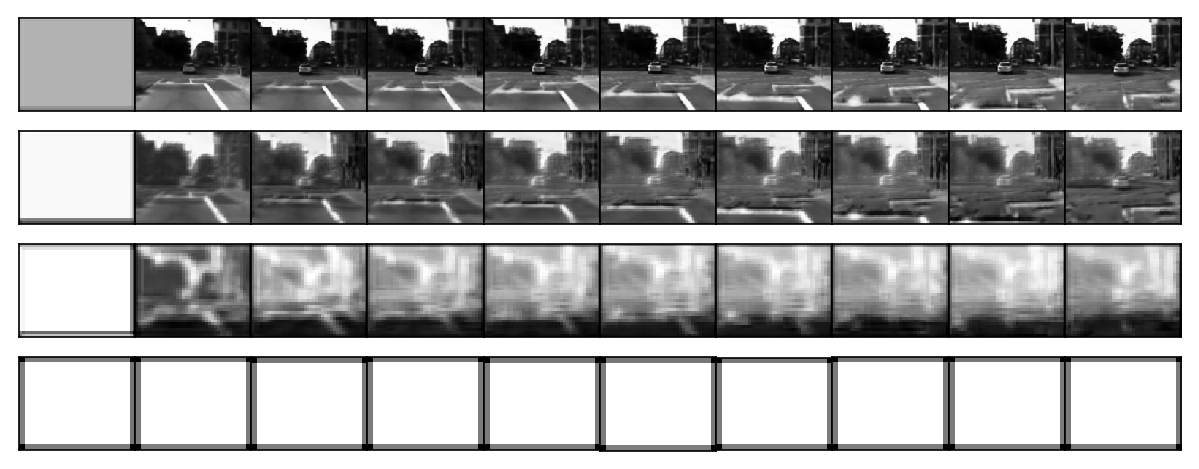

In [32]:
fig, axes = plt.subplots(4,10, figsize=(10,4), dpi=150)
batch = 0
for layer in range(4):
    layer_frames = np.arange(40)%4==layer
    count = 0
    for i in range(len(test_output)):
        if layer_frames[i] == 1:
            axes[layer, count].imshow(test_output[i].cpu()[batch].detach().numpy().mean(axis=0),
                                      cmap='Greys_r')
            axes[layer, count].set_xticks([])
            axes[layer, count].set_yticks([])
            count += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [3]:
model = PredNet(R_channels, A_channels, output_mode='error_all')
model.load_state_dict(torch.load('models/training_0030.pt'))
model.cuda()
model.eval()

AM_input = torch.unsqueeze(torch.from_numpy(np.array(AM_frames)[:,:,:,:3].transpose(0,3,1,2)), 0)
AM_input = AM_input.cuda()
AM_output = model(AM_input)


/home/jwpark/.local/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/jwpark/.local/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


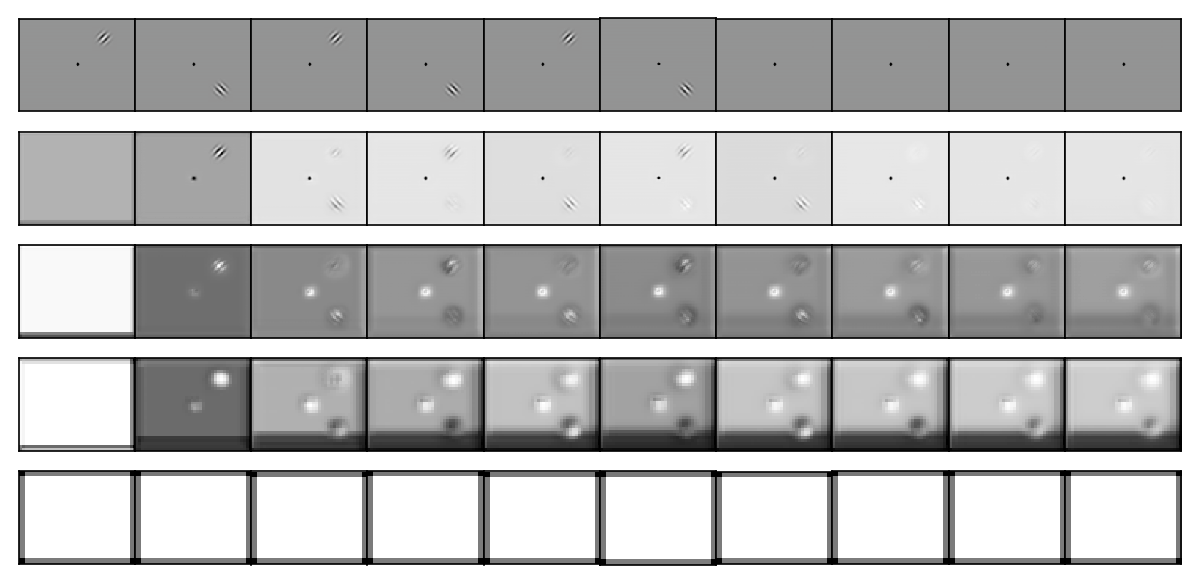

In [16]:
fig, axes = plt.subplots(5,10, figsize=(10,5), dpi=150)
batch = 0
for i in range(10):
    axes[0,i].imshow(AM_frames[i])
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

for layer in range(4):
    layer_frames = np.arange(40)%4==layer
    count = 0
    for i in range(len(AM_output)):
        if layer_frames[i] == 1:
            axes[layer+1, count].imshow(AM_output[i].cpu()[batch].detach().numpy().mean(axis=0),
                                      cmap='Greys_r')
            axes[layer+1, count].set_xticks([])
            axes[layer+1, count].set_yticks([])
            count += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [4]:
print(len(AM_output)) # 4, 4, 4, 4, 4, 4 ...
print(AM_output[3].shape)


40
torch.Size([1, 384, 16, 20])


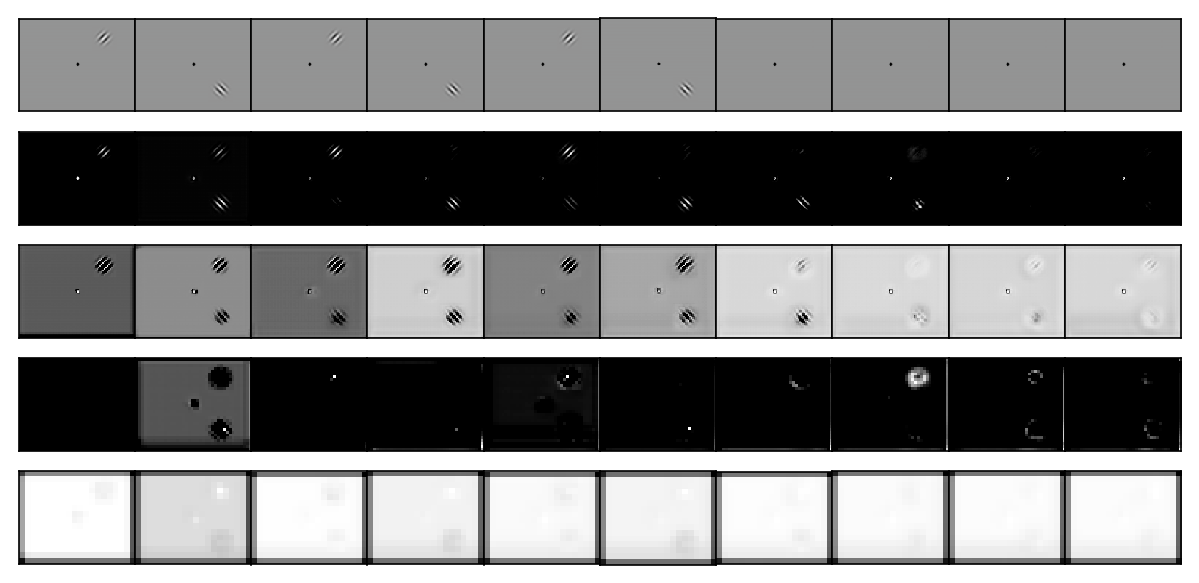

In [7]:
fig, axes = plt.subplots(5,10, figsize=(10,5), dpi=150)
batch = 0
kernels = [0, 0, 10, 10]
for i in range(10):
    axes[0,i].imshow(AM_frames[i])
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

for layer in range(4):
    layer_frames = np.arange(40)%4==layer
    count = 0
    for i in range(len(AM_output)):
        if layer_frames[i] == 1:
            axes[layer+1, count].imshow(AM_output[i].cpu()[batch].detach().numpy()[kernels[layer]],
                                      cmap='Greys_r')
            axes[layer+1, count].set_xticks([])
            axes[layer+1, count].set_yticks([])
            count += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


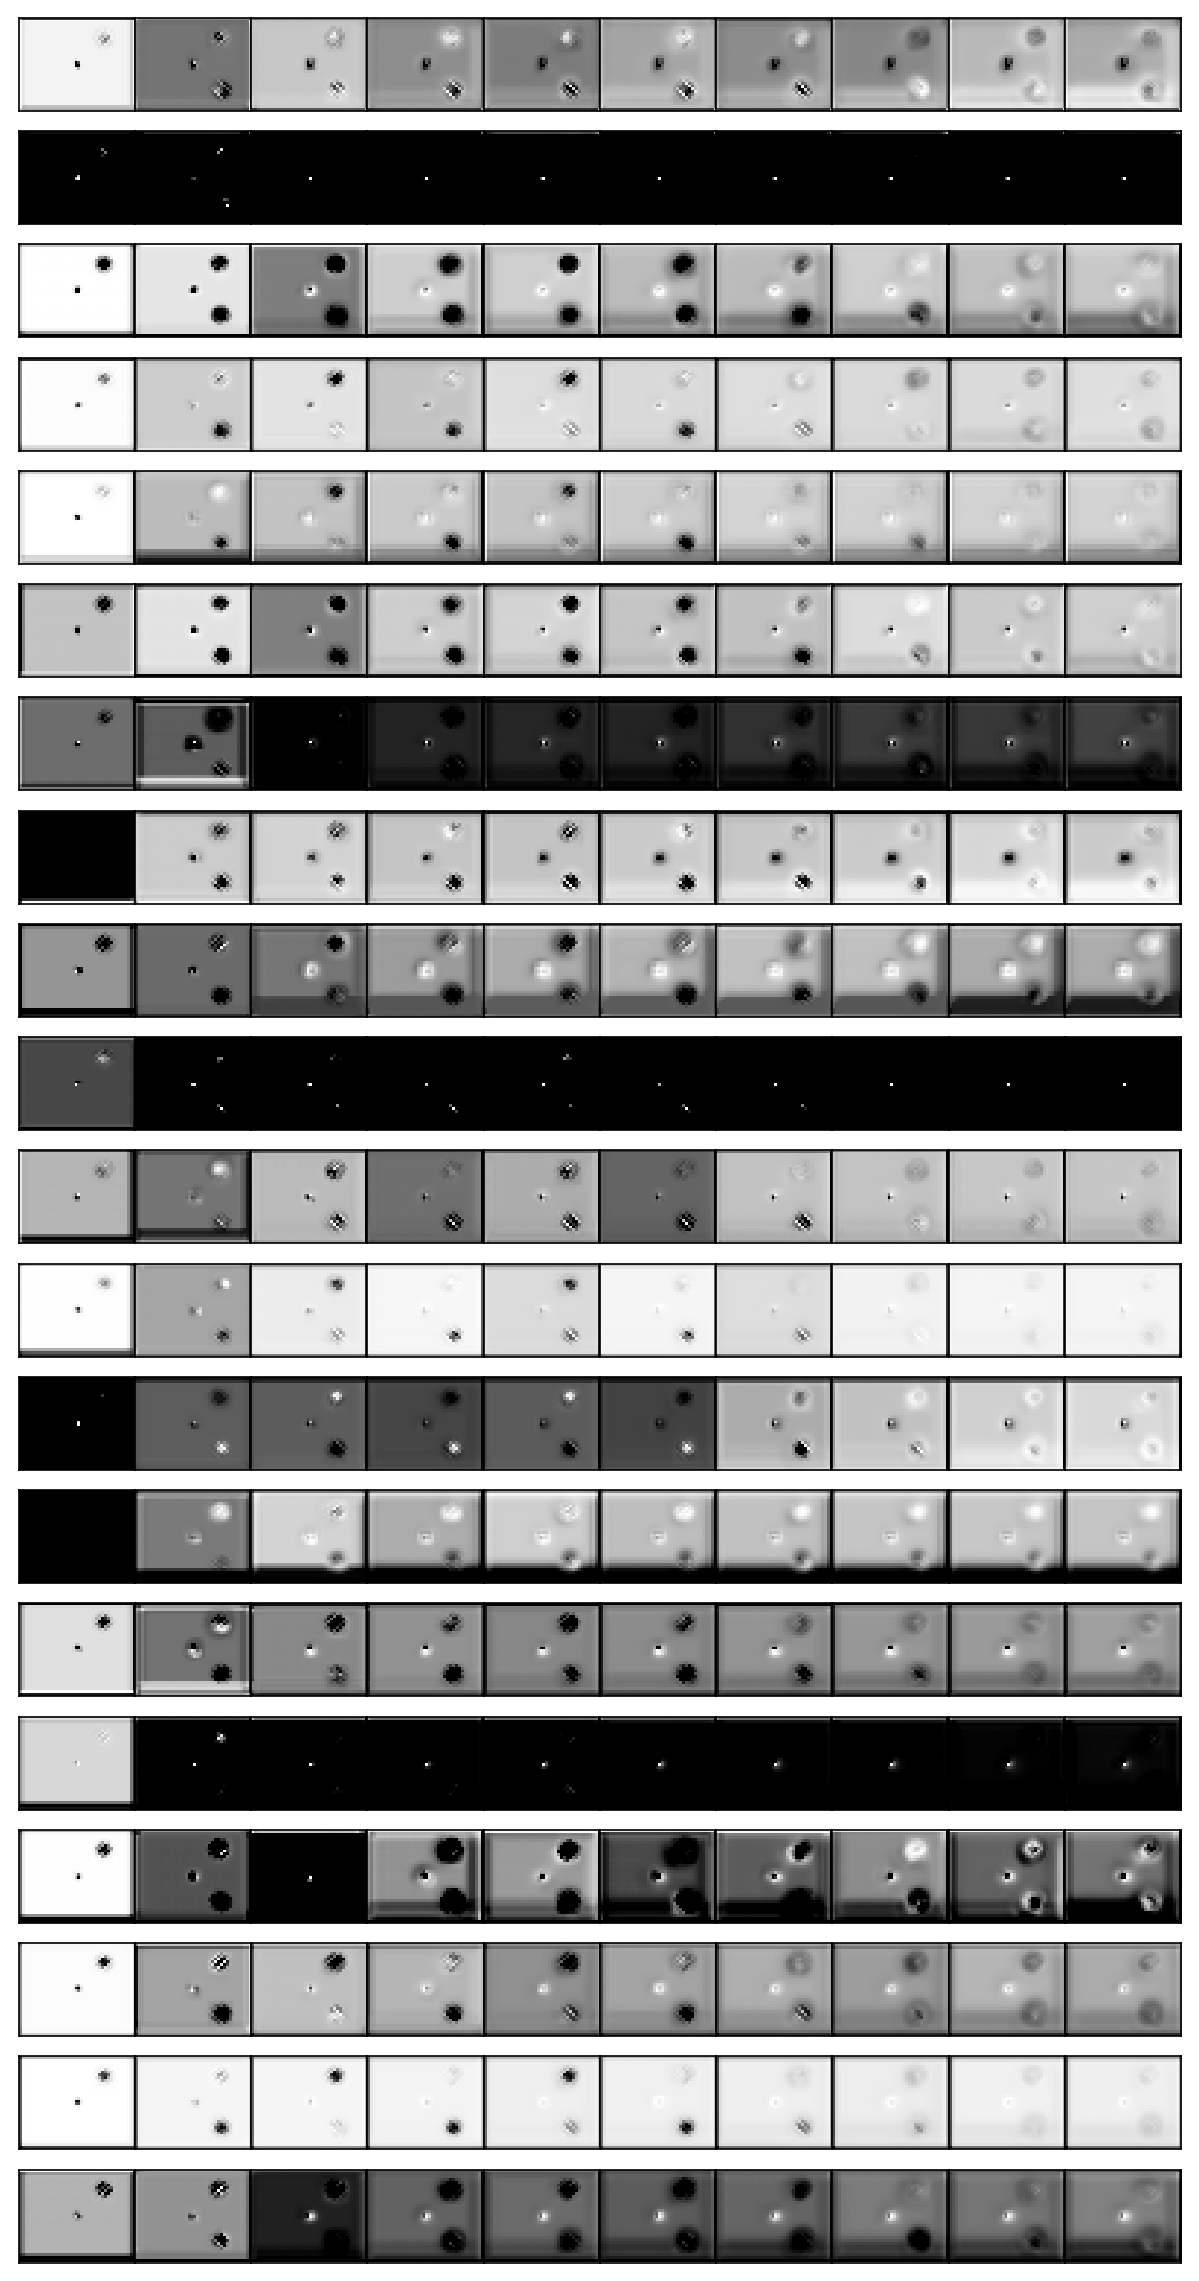

In [9]:
fig, axes = plt.subplots(20,10, figsize=(10,20), dpi=150)
batch = 0
layer = 2
for kernel in range(20):
    layer_frames = np.arange(40)%4==layer
    count = 0
    for i in range(len(AM_output)):
        if layer_frames[i] == 1:
            axes[kernel, count].imshow(AM_output[i].cpu()[batch].detach().numpy()[kernel+20],
                                      cmap='Greys_r')
            axes[kernel, count].set_xticks([])
            axes[kernel, count].set_yticks([])
            count += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
